In [1]:
# import sys
# from pathlib import Path

# project_path = Path().resolve().parent
# sys.path.append(str(project_path))

In [2]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go

from datetime import datetime
from statsmodels.tsa.seasonal import seasonal_decompose

import comexstat_viz.fetch_data as cfd

## 1. **Pre-processing**

In [3]:
df_pest = cfd.create_denfensivos_agricolas_df()

/home/hcordeiro/personal/venv/dviz/lib/python3.10/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api-comexstat.mdic.gov.br'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/home/hcordeiro/personal/venv/dviz/lib/python3.10/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api-comexstat.mdic.gov.br'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Data quality check passed - no NaNs or duplicates found.


In [4]:
df_pest_explore =  df_pest.copy()
df_pest_explore

,year,month,export_country,import_brazillian_state,transport_method,federal_agency,id_ncm,description_ncm,net_weight_kg,dt,extracted_at,export_country_code,is_domissanitario,is_herbicide,is_inseticide,is_fungicide,is_ddt,is_multiple_categories
0,2024,10,China,São Paulo,MARITIMA,0817800 - PORTO DE SANTOS,38089324,"herbicida à base de glifosato ou seus sais, de...",22475354.0,2024-10-01,2025-02-15 20:22:30.522235,CHN,False,True,False,False,False,False
1,2024,10,China,São Paulo,MARITIMA,0817800 - PORTO DE SANTOS,38089329,outros herbicidas apresentados de outro modo,18907628.0,2024-10-01,2025-02-15 20:22:30.522235,CHN,False,True,False,False,False,False
2,2024,08,China,São Paulo,MARITIMA,0817800 - PORTO DE SANTOS,38089329,outros herbicidas apresentados de outro modo,15503590.0,2024-08-01,2025-02-15 20:22:30.522235,CHN,False,True,False,False,False,False
3,2024,09,China,São Paulo,MARITIMA,0817800 - PORTO DE SANTOS,38089329,outros herbicidas apresentados de outro modo,14620184.0,2024-09-01,2025-02-15 20:22:30.522235,CHN,False,True,False,False,False,False
4,2024,07,China,São Paulo,MARITIMA,0817800 - PORTO DE SANTOS,38089324,"herbicida à base de glifosato ou seus sais, de...",12746527.0,2024-07-01,2025-02-15 20:22:30.522235,CHN,False,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51778,1997,05,Estados Unidos,Rio de Janeiro,AEREA,0717700 - AEROPORTO INTERNACIONAL DO RIO DE JA...,38089029,"outros rodenticidas/produtos semelhantes, apre...",0.0,1997-05-01,2025-02-15 20:22:30.522235,USA,False,False,False,False,False,False
51779,1997,05,Estados Unidos,São Paulo,AEREA,0817600 - AEROPORTO INTERNACIONAL DE SAO PAULO...,38083059,"outros reguladores de crescimento de plantas, ...",0.0,1997-05-01,2025-02-15 20:22:30.522235,USA,False,False,False,False,False,False
51780,1997,07,Estados Unidos,São Paulo,AEREA,0817600 - AEROPORTO INTERNACIONAL DE SAO PAULO...,38083029,outros herbicidas apresentados de outro modo,0.0,1997-07-01,2025-02-15 20:22:30.522235,USA,False,True,False,False,False,False
51781,1997,05,Estados Unidos,São Paulo,AEREA,0817600 - AEROPORTO INTERNACIONAL DE SAO PAULO...,38083021,"herbicida à base de 2, 4-d/de 2, 4-db/seus der...",0.0,1997-05-01,2025-02-15 20:22:30.522235,USA,False,True,False,False,False,False


In [5]:
df_pest_explore["description_ncm"].nunique(), df_pest_explore["id_ncm"].nunique()

(98, 113)

In [6]:
df_pest_explore.dtypes

year                               object
month                              object
export_country                     object
import_brazillian_state            object
transport_method                   object
federal_agency                     object
id_ncm                             object
description_ncm                    object
net_weight_kg                     float64
dt                         datetime64[ns]
extracted_at               datetime64[us]
export_country_code                object
is_domissanitario                    bool
is_herbicide                         bool
is_inseticide                        bool
is_fungicide                         bool
is_ddt                               bool
is_multiple_categories               bool
dtype: object

### Check duplicates and nans

In [7]:
df_pest_explore.isna().any()

year                       False
month                      False
export_country             False
import_brazillian_state    False
transport_method           False
federal_agency             False
id_ncm                     False
description_ncm            False
net_weight_kg              False
dt                         False
extracted_at               False
export_country_code        False
is_domissanitario          False
is_herbicide               False
is_inseticide              False
is_fungicide               False
is_ddt                     False
is_multiple_categories     False
dtype: bool

In [8]:
df_pest_explore.duplicated().any()

np.False_

In [9]:
df_pest_explore.to_csv("./2025_01_28_processed_export_data.csv")

### Group per month and class, melted output

In [10]:
value_keys = ["net_weight_kg"]
dt_keys = ["dt"]
one_hot_keys = ['is_domissanitario', 'is_herbicide', 'is_inseticide', 'is_fungicide']

_df_keys = value_keys + dt_keys + one_hot_keys

In [11]:
# Aggregate the sum of 'value' for each class
class_sums = df_pest_explore[_df_keys].groupby(dt_keys + one_hot_keys).sum().reset_index()

In [12]:
# Melt the DataFrame to have one row per class
melted_agg_df = class_sums.melt(id_vars=dt_keys + value_keys,
                         value_vars=one_hot_keys, 
                         var_name='class', 
                         value_name='is_present')

melted_agg_df

,dt,net_weight_kg,class,is_present
0,1997-01-01,85844.0,is_domissanitario,False
1,1997-01-01,51020.0,is_domissanitario,False
2,1997-01-01,358772.0,is_domissanitario,False
3,1997-01-01,620160.0,is_domissanitario,False
4,1997-01-01,169926.0,is_domissanitario,True
...,...,...,...,...
9139,2024-12-01,10666796.0,is_fungicide,False
9140,2024-12-01,34660894.0,is_fungicide,False
9141,2024-12-01,408500.0,is_fungicide,False
9142,2024-12-01,745.0,is_fungicide,True


In [13]:
melted_agg_df = melted_agg_df[melted_agg_df['is_present'] == 1]  # keep only values of classes that existed in the og data

In [14]:
melted_agg_df = melted_agg_df.drop(columns=["is_present"])

## 2. **Timeseries Analysis**

In [15]:
sum_df = df_pest_explore[dt_keys + value_keys].groupby(dt_keys).sum()
moving_avg_df = sum_df.rolling(window=12).mean()
moving_avg_sr = moving_avg_df["net_weight_kg"]

moving_avg_sr

dt
1997-01-01             NaN
1997-02-01             NaN
1997-03-01             NaN
1997-04-01             NaN
1997-05-01             NaN
                  ...     
2024-08-01    5.579110e+07
2024-09-01    5.765752e+07
2024-10-01    6.040717e+07
2024-11-01    5.969979e+07
2024-12-01    6.067162e+07
Name: net_weight_kg, Length: 336, dtype: float64

In [16]:
monthly_ts_df = df_pest_explore[dt_keys+value_keys].resample("ME", on="dt").sum()
monthly_ts_df

,net_weight_kg
dt,
1997-01-31,1520500.0
1997-02-28,914151.0
1997-03-31,2002724.0
1997-04-30,1021449.0
1997-05-31,1331606.0
...,...
2024-08-31,82234164.0
2024-09-30,100434063.0
2024-10-31,112106283.0


In [17]:
decomposed_ts = seasonal_decompose(monthly_ts_df)

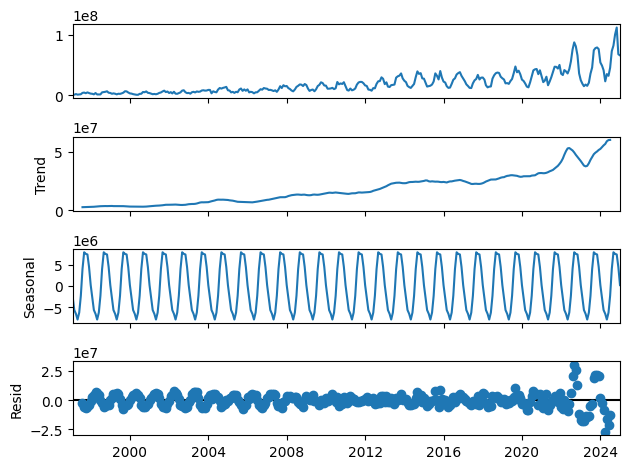

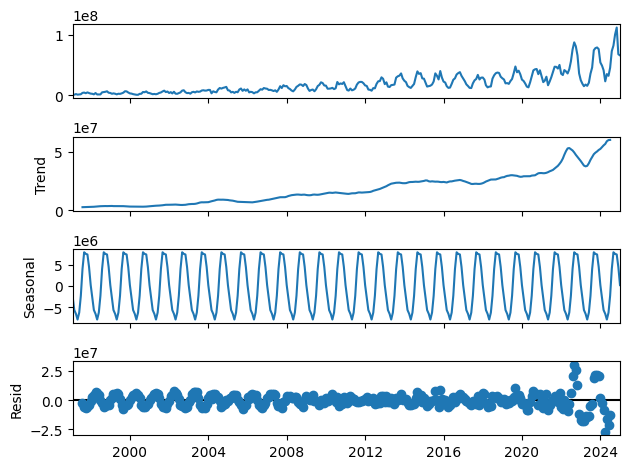

In [30]:
decomposed_ts.plot()

In [18]:
fig = px.bar(
    melted_agg_df,
    x="dt",
    y="net_weight_kg",
    color="class"
)

# Add a line trace
fig.add_trace(go.Scatter(
    x=decomposed_ts.trend.index,  # Use the same x-axis values as the bar plot
    y=decomposed_ts.trend.values,  # Use the same y-axis values or a different column for the line
    mode='lines',  # Display as a line with markers
    name='Trend',  # Name for the legend
    line=dict(color='saddlebrown', width=2.5)  # Customize the line color and width
))

fig.show()

## 3: **Last Decade**

In [19]:
df_last_decade = melted_agg_df.query("dt > '2015-01-01'")

In [20]:
df_grouped_classes = df_last_decade.groupby("class")[value_keys].sum().reset_index()
df_grouped_classes

,class,net_weight_kg
0,is_domissanitario,3.338843e+08
1,is_fungicide,8.906562e+08
2,is_herbicide,2.017611e+09
3,is_inseticide,1.000382e+09


In [21]:
fig = px.bar(
    df_grouped_classes,
    x="class",
    y="net_weight_kg",
    color="class"
)

fig.show()  # TODO padronize colors

## 4: **Countries**

In [22]:
country_to_iso3 = {
    'Alemanha': 'DEU',  # Germany
    'Antilhas Holandesas': 'ANT',  # Netherlands Antilles (Note: This entity no longer exists as a country)
    'Argentina': 'ARG',
    'Austrália': 'AUS',  # Australia
    'Belarus': 'BLR',
    'Brasil': 'BRA',  # Brazil
    'Bulgária': 'BGR',  # Bulgaria
    'Bélgica': 'BEL',  # Belgium
    'Canadá': 'CAN',  # Canada
    'Cayman, Ilhas': 'CYM',  # Cayman Islands
    'Chile': 'CHL',
    'China': 'CHN',
    'Cocos (Keeling), Ilhas': 'CCK',  # Cocos (Keeling) Islands
    'Colômbia': 'COL',  # Colombia
    'Coreia do Norte': 'PRK',  # North Korea
    'Coreia do Sul': 'KOR',  # South Korea
    'Costa Rica': 'CRI',
    'Cuba': 'CUB',
    'Dinamarca': 'DNK',  # Denmark
    'Emirados Árabes Unidos': 'ARE',  # United Arab Emirates
    'Equador': 'ECU',  # Ecuador
    'Eslovênia': 'SVN',  # Slovenia
    'Espanha': 'ESP',  # Spain
    'Estados Unidos': 'USA',  # United States
    'Filipinas': 'PHL',  # Philippines
    'Finlândia': 'FIN',  # Finland
    'França': 'FRA',  # France
    'Grécia': 'GRC',  # Greece
    'Guatemala': 'GTM',
    'Hong Kong': 'HKG',  # Hong Kong (Special Administrative Region of China)
    'Hungria': 'HUN',  # Hungary
    'Indonésia': 'IDN',  # Indonesia
    'Inglaterra': 'GBR',  # England (part of the United Kingdom)
    'Irlanda': 'IRL',  # Ireland
    'Israel': 'ISR',
    'Itália': 'ITA',  # Italy
    'Iugoslávia': 'YUG',  # Yugoslavia (Note: This entity no longer exists as a country)
    'Japão': 'JPN',  # Japan
    'Jordânia': 'JOR',  # Jordan
    'Lituânia': 'LTU',  # Lithuania
    'Macau': 'MAC',  # Macau (Special Administrative Region of China)
    'Malta': 'MLT',
    'Malásia': 'MYS',  # Malaysia
    'México': 'MEX',  # Mexico
    'Nigéria': 'NGA',  # Nigeria
    'Noruega': 'NOR',  # Norway
    'Nova Zelândia': 'NZL',  # New Zealand
    'Panamá': 'PAN',  # Panama
    'Paquistão': 'PAK',  # Pakistan
    'Paraguai': 'PRY',  # Paraguay
    'Países Baixos (Holanda)': 'NLD',  # Netherlands
    'Peru': 'PER',
    'Polônia': 'POL',  # Poland
    'Porto Rico': 'PRI',  # Puerto Rico (Territory of the United States)
    'Portugal': 'PRT',
    'Reino Unido': 'GBR',  # United Kingdom
    'República Dominicana': 'DOM',  # Dominican Republic
    'Rússia': 'RUS',  # Russia
    'Singapura': 'SGP',  # Singapore
    'Sudão': 'SDN',  # Sudan
    'Suécia': 'SWE',  # Sweden
    'Suíça': 'CHE',  # Switzerland
    'Tailândia': 'THA',  # Thailand
    'Taiwan (Formosa)': 'TWN',  # Taiwan (Province of China)
    'Tcheca, República': 'CZE',  # Czech Republic
    'Turquia': 'TUR',  # Turkey
    'Uruguai': 'URY',  # Uruguay
    'Venezuela': 'VEN',
    'Vietnã': 'VNM',  # Vietnam
    'África do Sul': 'ZAF',  # South Africa
    'Áustria': 'AUT',  # Austria
    'Índia': 'IND'  # India
}

In [23]:
# Aggregate data by country (sum of peso_liq_kg)
country_aggregated_df = df_pest_explore.groupby("export_country", as_index=False)["net_weight_kg"].sum()
country_aggregated_df

,export_country,net_weight_kg
0,Alemanha,1.347858e+08
1,Antilhas Holandesas,4.043500e+04
2,Argentina,1.112158e+09
3,Austrália,1.021205e+07
4,Belarus,7.837210e+05
...,...,...
67,Venezuela,5.371400e+04
68,Vietnã,5.499300e+05
69,África do Sul,1.444039e+08
70,Áustria,1.646679e+07


In [24]:
country_aggregated_df["country_iso"] = country_aggregated_df["export_country"].map(country_to_iso3)

In [25]:
fig = px.choropleth(
    country_aggregated_df,
    locations="country_iso",  # Column with country names
    locationmode="ISO-3",  # Use country names for locations
    color="net_weight_kg",  # Column to determine color intensity
    hover_name="country_iso",  # Column to display on hover
    color_continuous_scale="Viridis",  # Choose a colorscale
    title="Peso Liq (kg) per Country"
)

# Show the plot
fig.show()

## 4: **Transport Method**

In [26]:
transport_aggregated_df = df_pest_explore.groupby("transport_method", as_index=False)["net_weight_kg"].sum()
transport_aggregated_df

,transport_method,net_weight_kg
0,AEREA,5.375096e+07
1,ENTRADA/SAIDA FICTA,4.314336e+07
2,FERROVIARIA,6.056493e+07
3,MARITIMA,5.211051e+09
4,MEIOS PROPRIOS,1.805700e+04
5,POSTAL,4.700000e+02
6,RODOVIARIA,1.029518e+09


In [27]:
transport_aggregated_df.loc[transport_aggregated_df["net_weight_kg"] < 1e9, "transport_method"] = "OUTROS"

In [28]:
fig = px.bar(
    transport_aggregated_df,
    x="transport_method",
    y="net_weight_kg",
    color="transport_method"
)

fig.show()